<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/nyandwi/machine_learning_complete/blob/main/9_nlp_with_tensorflow/5_using_pretrained_bert_for_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

*This notebook was created by [Jean de Dieu Nyandwi](https://twitter.com/jeande_d) for the love of machine learning community. For any feedback, errors or suggestion, he can be reached on email (johnjw7084 at gmail dot com), [Twitter](https://twitter.com/jeande_d), or [LinkedIn](https://linkedin.com/in/nyandwi).*

<a name='0'></a>
# Using Pretrained BERT for Text Classification

## Contents 

* [1. Intro to BERT](#1)
* [2. In Practice: Finetuning a Pretrained BERT](#2)
   * [2.1 Getting the data](#2-1)
   * [2.2 Preparing the data](#2-2)
   * [2.3 Getting the BERT and its preprocesing model from TensorFlow Hub](#2-3)
   * [2.4 Building a news classifier](#2-4)
   * [2.5 Training a finetuned BERT model](#2-4)
   * [2.6 Visualizing the model results](#2-4)
   * [2.7 Performing the inference on new texts](#2-4)

* [3. Futher learning](#3)

<a name='1'></a>
## 1. Intro to BERT

BERT stands for Bidirectional Encoder Representations from Transformers. It is one of the recent state of the art language models that can be used for variety of tasks such as question answering, text classification, machine translation and so forth. 

As it sounds and hence the name, BERT is based on Transformers. Transformers are a neural network type architecture that uses attention mechanisms([Attention is All you Need](https://arxiv.org/pdf/1706.03762.pdf))

BERT is deeply bidirectional: it captures the full context of the input text (converted to tokens) from both directions. The traditional language models (e.g [Word2vec](https://arxiv.org/abs/1301.3781)) are undirectional and thus, they don't take into account the context of each occurence of a given word. 

To quote its [paper](https://arxiv.org/pdf/1810.04805.pdf), BERT also uses a `next word prediction` task that jointly pretrains text-pair representations. 



TensorFlow Hub contains many version of [BERT](https://tfhub.dev/google/collections/bert/1) such as: [Small BERT](https://tfhub.dev/google/collections/bert/1), [Albert](https://tfhub.dev/google/collections/albert/1), [Electra](https://tfhub.dev/google/collections/albert/1), [BERT Expert](https://tfhub.dev/google/collections/experts/bert/1). 

<a name='2'></a>

## 2. In Practice: Finetuning a Pretrained BERT

We are going to use `ag_news_subset` dataset that is available in [TensorFlow datasets](https://www.tensorflow.org/datasets/catalog/ag_news_subset). TensorFlow datasets is a collection of awesome datasets that can be used right away with little preparations. 

AG is a collection of more than 1 million news articles gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. 

The AG dataset contains 4 classes that are: World(0), Sports(1), Business(2), Sci/Tech(3). The total number of training samples is 120,000 and testing 7,600. Each class contains 30,000 training samples and 1,900 testing samples. 

You can learn more about the dataset [here](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html).


Let's get the dataset from TensorFlow datasets.

<a name='2-1'></a>

## 2.1 Getting the Data

#### Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub

The dataset that we are going to download has only one version so far. Let's specify it so that when it is updated, our lab will not be affected. If loading the data fails, run the cell again. It happens sometime when loading datasets from TF datasets.

In [3]:
(train_data, val_data), info = tfds.load('ag_news_subset:1.0.0', #version 1.0.0
                                         split=('train', 'test'),
                                         with_info=True, 
                                         as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ag_news_subset/1.0.0.incompleteIWSQ9J/ag_news_subset-train.tfrecord


  0%|          | 0/120000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ag_news_subset/1.0.0.incompleteIWSQ9J/ag_news_subset-test.tfrecord


  0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news_subset downloaded and prepared to /root/tensorflow_datasets/ag_news_subset/1.0.0. Subsequent calls will reuse this data.


Now that we have the data, we can look into some examples. This is always a good practice. 

Printing `info` that we loaded with the dataset, we can see pretty much everything we would need to know about the data. 

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [5]:
# Displaying the classes

class_names = info.features['label'].names
num_classes = info.features['label'].num_classes

print(f'The news are grouped into {num_classes} classes that are :{class_names}')

The news are grouped into 4 classes that are :['World', 'Sports', 'Business', 'Sci/Tech']


In [6]:
num_train = info.splits['train'].num_examples
num_val = info.splits['test'].num_examples

print(f'The number of training samples: {num_train} \nThe number of validation samples: {num_val}')

The number of training samples: 120000 
The number of validation samples: 7600


We can also display the first 10 news samples. We can use [`tfds.as_dataframe`](https://www.tensorflow.org/datasets/api_docs/python/tfds/as_dataframe) to display them as dataframe.

In [7]:
news_df = tfds.as_dataframe(train_data.take(10), info)

news_df.head(10)

,description,label
0,b'AMD #39;s new dual-core Opteron chip is desi...,3
1,b'Reuters - Major League Baseball\\Monday anno...,1
2,b'President Bush #39;s quot;revenue-neutral q...,2
3,b'Britain will run out of leading scientists u...,3
4,"b'London, England (Sports Network) - England m...",1
5,b'TOKYO - Sony Corp. is banking on the \\$3 bi...,0
6,b'Giant pandas may well prefer bamboo to lapto...,3
7,"b'VILNIUS, Lithuania - Lithuania #39;s main pa...",0
8,b'Witnesses in the trial of a US soldier charg...,0
9,"b'Dan Olsen of Ponte Vedra Beach, Fla., shot a...",1


Let's display some full news.

In [8]:
for i in range (0,4):

  print(f"Sample news {i}\n \
  Label: {news_df['label'][i]} {(class_names[i])}\n \
  Description: {news_df['description'][i]}\n----------\n")

Sample news 0
   Label: 3 World
   Description: b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
----------

Sample news 1
   Label: 1 Sports
   Description: b'Reuters - Major League Baseball\\Monday announced a decision on the appeal filed by Chicago Cubs\\pitcher Kerry Wood regarding a suspension stemming from an\\incident earlier this season.'
----------

Sample news 2
   Label: 2 Business
   Description: b'President Bush #39;s  quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.'
----------

Sample news 3
   Label: 3 Sci/Tech
   Description: b'Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.'
----------



In [9]:
news_df.columns

Index(['description', 'label'], dtype='object')

Now that we understand the data, let's prepare it before we can use LSTMs to classify the news.  

<a name='2-2'></a>

## 2.2 Preparing the Data

For this practice of using a pretrained BERT, we will not need to vectorize the data. We will feed the sentences directly to the model. 

Let's just only shuffle and batch the training data. For validation data, we don't shuffle. We only batch it.

In [10]:
buffer_size = 1000
batch_size = 32

train_data = train_data.shuffle(buffer_size)
train_data = train_data.batch(batch_size).prefetch(1)
val_data = val_data.batch(batch_size).prefetch(1)

In [11]:
for news, label in train_data.take(1):

  print(f'Sample news\n----\n {news.numpy()[:4]} \n----\nCorresponding labels: {label.numpy()[:4]}')

Sample news
----
 [b'RAMALLAH: Palestinian leader Yasser Arafat is  quot;very, very sick quot; and the ex-guerrilla who for decades symbolised a struggle for statehood is slipping in and out of consciousness, officials and medics said today.'
 b'AOL said it was intent on making travel an important part of its content expansion, which increasingly includes general Web properties that all Internet users can access as well as content just '
 b'AP - WHAT WAS FOUND: A microscopic diamond embedded in kimberlite, the molten rock in which diamonds are found, in Montana.'
 b'The US military in Iraq has denied reports that the former Iraqi leader Saddam Hussein is on hunger strike. But a spokesman told the BBC that some of his former aides who are also in custody, including  quot;Chemical '] 
----
Corresponding labels: [0 2 3 0]


<a name='2-3'></a>

## 2.3 Getting the BERT Model and its Preprocessing Model from TF Hub

There many versions of BERT that are optimized for different use cases. The choice of a given version is going to depend on computation time & speed, accuracy, and the size of that particular BERT version. 

For our case, we can use [SmallBERT](https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3). It is also worth mentioning that each BERT model has its preprocessing model that will convert the texts into tokens. The BERT models and their corresponding preprocesing models are pretty detailed on [TensorFlow Hub BERT models page](https://tfhub.dev/google/collections/bert/1). 

The preprocessing model use [TensorFlow Text](https://www.tensorflow.org/text) operations. We have to install it. 

In [12]:
!pip install tensorflow_text
import tensorflow_text as text

     |████████████████████████████████| 4.4 MB 5.1 MB/s 


In [13]:
bert_handle = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2'
preprocessing_model = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

Let's wrap `preprocessing_model` into a [KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) and test it on some sample sentences. 

In [14]:
preprocess_layer = hub.KerasLayer(preprocessing_model)

The output of [preprocess model](https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3) is made of 3 elements or keys that are:   `input_word_ids`, `input_mask`, `input_type_ids`. Here are what they mean.

* `input_word_ids`: has the token ids of the input sequences.
* `input_mask`: has value 1 at the position of all input tokens present before padding and value 0 for the padding tokens.

* `input_type_ids`: has the index of the input segment that gave rise to the input token at the respective position. The first input segment (index 0) includes the start-of-sequence token and its end-of-segment token. The second segment (index 1, if present) includes its end-of-segment token. Padding tokens get index 0 again.

Source: [TF Hub doc](https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3).

In [15]:
sample_news = ['Tech rumors: The tech giant Apple is working on its self driving car']

preprocessed_news = preprocess_layer(sample_news)

print(f'Keys       : {list(preprocessed_news.keys())}')
print(f'Shape      : {preprocessed_news["input_word_ids"].shape}')
print(f'Word Ids   : {preprocessed_news["input_word_ids"][0, :5]}')
print(f'Input Mask : {preprocessed_news["input_mask"][0, :5]}')
print(f'Type Ids   : {preprocessed_news["input_type_ids"][0, :5]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  6627 11256  1024  1996]
Input Mask : [1 1 1 1 1]
Type Ids   : [0 0 0 0 0]


We can also see what kinds of the output the BERT model will give if we feed it the preprocessed texts. 

The bert model expect 3 input tensors: `input_word_ids`, `input_mask`, `input_type_ids`.

In [16]:
bert_model = hub.KerasLayer(bert_handle)

The `bert_model` returns 2 main keys: `pooled_output`, `sequence_output`. 

Here are what they mean:

* `pooled_output` represents the  input sequence.
* `sequence_output` denotes each input token in the context. 

Any of those keys can be used as input to the rest of the model. We will see that later.



In [17]:
bert_outputs = bert_model(preprocessed_news)

print(f'Pooled output shape:{bert_outputs["pooled_output"].shape}')
print(f'Pooled output values:{bert_outputs["pooled_output"][0, :5]}')
print(f'Sequence output shape:{bert_outputs["sequence_output"].shape}')
print(f'Sequence output values:{bert_outputs["sequence_output"][0, :5]}')

Pooled output shape:(1, 512)
Pooled output values:[ 0.944598    0.9861868  -0.15102872  0.17372097 -0.6424564 ]
Sequence output shape:(1, 128, 512)
Sequence output values:[[-0.60826176  0.2623035   1.2436793  ... -0.8821719   0.36095393
  -0.00184657]
 [ 0.33820462  0.07993765  1.1374032  ... -1.6438915  -1.0649079
  -0.7371688 ]
 [-0.6054905  -0.14994524  0.8464851  ... -0.74730563  0.84758896
   0.13153419]
 [ 0.06868989  0.6969774   1.5265335  ... -0.7680908  -0.30986136
   0.25017208]
 [-1.2314899   1.4334055  -0.37746784 ... -1.3110946  -0.01984588
   0.7904873 ]]


Now that we understand what the ins and outs of [bert model](https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2) and its [preprocessor](https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3), let's build the rest of the model. 

<a name='2-4'></a>

## 2.4 Building a News Classifier with BERT

Since the main purpose of this practice it to finetune BERT, we are going to add few more layers to it. 

We will add dropout for regularization, and dense layers for classification purpose. 

We have been using [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential). There is also a Functional API. This API type make it easy to build flexible models where you can arrange layers in a way you want. Also, Functional API is a suitable API type for the models that take multiple inputs and outputs. 

In [18]:
input_text = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Input')

# A preprocesing model before layer BERT
preprocessing_layer = hub.KerasLayer(preprocessing_model, name='preprocessing_layer')

bert_input = preprocessing_layer(input_text)

# Getting a Bert model, set trainable to True
bert_encoder = hub.KerasLayer(bert_handle, trainable=True, name='bert_encoder')

bert_outputs = bert_encoder(bert_input)

# For finetuning, we take pooled_output
pooled_bert_output = bert_outputs['pooled_output']

# Adding a dense layer 

dense_net = tf.keras.layers.Dense(16, activation='relu', name='fully_connected_layer')(pooled_bert_output)
# Add dropout layer for regularization
dense_net = tf.keras.layers.Dropout(0.2)(dense_net)

# Last dense layer for classification purpose
final_output = tf.keras.layers.Dense(4, activation='softmax', name='classifier')(dense_net)

# Combine input and output

news_classifier = tf.keras.Model(input_text, final_output)

We can display the model summary.

In [19]:
news_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing_layer (KerasLayer {'input_word_ids': ( 0           Input[0][0]                      
__________________________________________________________________________________________________
bert_encoder (KerasLayer)       {'encoder_outputs':  28763649    preprocessing_layer[0][0]        
                                                                 preprocessing_layer[0][1]        
                                                                 preprocessing_layer[0][2]        
______________________________________________________________________________________________

Or plot it with `tf.keras.utils.plot_model()`

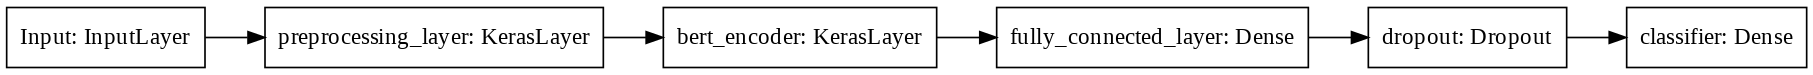

In [20]:
tf.keras.utils.plot_model(news_classifier, rankdir='LR', dpi=120)

We can change the model plot orientation by setting the `rankdir` to either `TB` (top-bottom) or `LR` (left-right).

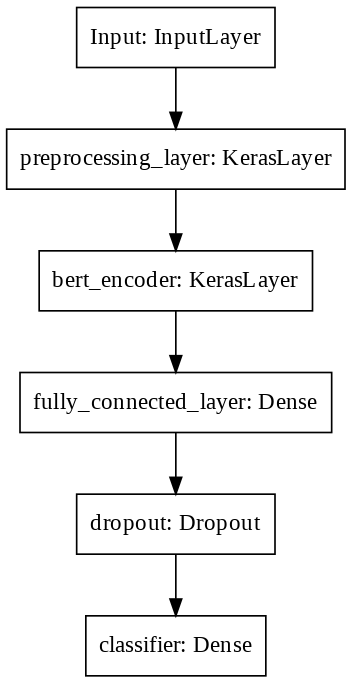

In [21]:
tf.keras.utils.plot_model(news_classifier, rankdir='TB', dpi=120)

<a name='2-5'></a>

## 2.5 Training a Finetuned BERT

Before training a model, we have to compile it. When compiling the model, we specify the loss and optimization function. 

Loss function is there to measure how far the predictions are from the actual outputs, and optimizer to reduce the loss. 

In [22]:
news_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), 
                        loss='sparse_categorical_crossentropy', 
                        metrics=['accuracy'])

In [23]:
# Train the model

batch_size = 32

train_steps = int(len(train_data)/batch_size)
val_steps = int(len(val_data)/batch_size)

history = news_classifier.fit(train_data, 
                    epochs=15,
                    validation_data=val_data,
                    steps_per_epoch=train_steps,
                    validation_steps=val_steps
)

Epoch 1/15
117/117 [==============================] - 872s 7s/step - loss: 0.9071 - accuracy: 0.5710 - val_loss: 0.7042 - val_accuracy: 0.6205
Epoch 2/15
117/117 [==============================] - 865s 7s/step - loss: 0.6153 - accuracy: 0.7639 - val_loss: 0.4422 - val_accuracy: 0.8839
Epoch 3/15
117/117 [==============================] - 867s 7s/step - loss: 0.4662 - accuracy: 0.8288 - val_loss: 0.3497 - val_accuracy: 0.8929
Epoch 4/15
117/117 [==============================] - 865s 7s/step - loss: 0.4057 - accuracy: 0.8632 - val_loss: 0.3616 - val_accuracy: 0.8973
Epoch 5/15
117/117 [==============================] - 866s 7s/step - loss: 0.3775 - accuracy: 0.8659 - val_loss: 0.3295 - val_accuracy: 0.9107
Epoch 6/15
117/117 [==============================] - 863s 7s/step - loss: 0.3795 - accuracy: 0.8657 - val_loss: 0.3112 - val_accuracy: 0.9062
Epoch 7/15
117/117 [==============================] - 859s 7s/step - loss: 0.3613 - accuracy: 0.8707 - val_loss: 0.3071 - val_accuracy: 0.9107

<a name='2-6'></a>

## 2.6 Visualizing the Model Results

It is always a good practice to plot the model results. When doing error analysis, plotting learning curve becomes helpful. 

Let's plot the loss and accuracy over on the course of epochs.

In [24]:
# function to plot accuracy and loss

def plot_acc_loss(history):

  model_history = history.history
  acc = model_history['accuracy']
  val_acc = model_history['val_accuracy']
  loss = model_history['loss']
  val_loss = model_history['val_loss']
  epochs = history.epoch

  plt.figure(figsize=(10,5))
  plt.plot(epochs, acc, 'r', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)

  # Create a new figure with plt.figure()
  plt.figure()

  plt.figure(figsize=(10,5))
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'y', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  plt.show()

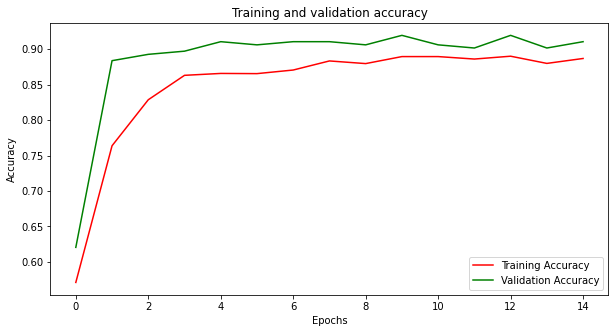

<Figure size 432x288 with 0 Axes>

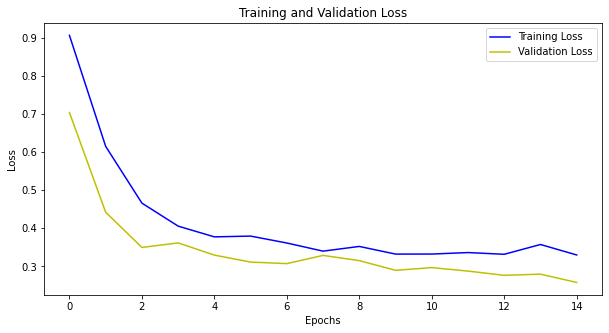

In [25]:
plot_acc_loss(history)

Looking on the learning curve, we could have trained the model for fewer epochs, like 9 or 10 because after 9, there seems to be no improvements. 

<a name='2-7'></a>

## 2.7 Performing Inference on New Texts

In [26]:
def predict(model, sample_news, class_names):

  # Convert sample news into array

  sample_news = np.array(sample_news)

  # Predict the news type

  preds = model.predict(sample_news)

  pred_class = np.argmax(preds[0])

  print(f'predicted class: {pred_class} \nPredicted Class name: {class_names[pred_class]}')


In [27]:
sample_news = ['Tesla, a self driving car company is also planning to make a humanoid robot. This humanoid robot appeared dancing in the latest Tesla AI day']

predict(news_classifier, sample_news, class_names)

predicted class: 3 
Predicted Class name: Sci/Tech


In [28]:
sample_news = ["In the last weeks, there has been many transfer suprises in footbal. Ronaldo went back to Old Trafford, "
                "while Messi went to Paris Saint Germain to join his former colleague Neymar."
                "We can't wait to see these two clubs will perform in upcoming leagues"]
            

predict(news_classifier, sample_news, class_names)

predicted class: 1 
Predicted Class name: Sports


In [33]:
sample_news = ["In the latest tech news: The tech giant NVIDIA has acquired ARM, a microproccessor company"]
            

predict(news_classifier, sample_news, class_names)

predicted class: 3 
Predicted Class name: Sci/Tech


In [35]:
sample_news = ["Salesforce reported making over 1B sales in last quarter"]
            

predict(news_classifier, sample_news, class_names)

predicted class: 2 
Predicted Class name: Business


<a name='3'></a>

# 3. Further Learning

We have learned about BERT (Bidirectional Encoder Representation Transformer) and how to finetune it to model basic NLP tasks such as text classification. 

If you would like to learn more about BERT and Text Classification, here are resources to use:

* [TensorFlow official text classification with BERT tutorial](https://tfhub.dev/google/collections/bert/1)
* [BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding](https://arxiv.org/pdf/1810.04805.pdf)
* [BERT Models in TensorFlow Hub](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)

## [BACK TO TOP](#0)